# Image Filtering

### Rank Filters -  Mean, Median and,  Gaussian Filter

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, io, color,img_as_ubyte
from skimage.filters.rank import median, mean
from skimage.morphology import disk

C:\Users\ashis\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
#Set colormap to grayscale and turning off pixel interpolation
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

### Local filtering

The "local" in local filtering simply means that a pixel is adjusted by values in some surrounding neighborhood. These surrounding elements are identified or weighted based on a "footprint", "structuring element", or "kernel".

Let's go to back to basics and look at a 1D step-signal

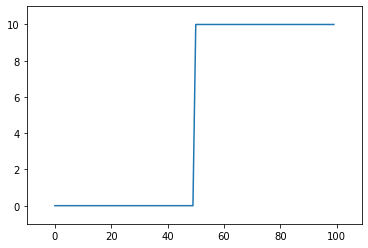

In [3]:
step_signal = np.zeros(100)
step_signal[50:] = 10
plt.plot(step_signal)
plt.margins(0.1)

Now add some (very) artificial noise to this signal:

[::y] means every yth element from the list / array

[ 1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0.  1.  0. 11. 10. 11. 10.
 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10.
 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10. 11. 10.
 11. 10. 11. 10. 11. 10. 11. 10. 11. 10.]


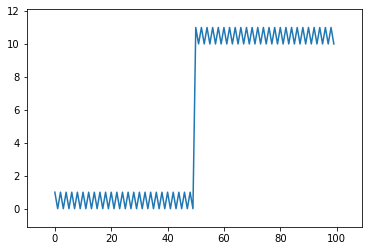

In [4]:
noisy_signal = np.copy(step_signal)
noisy_signal[::2] += 1
print(noisy_signal)
plt.plot(noisy_signal)
plt.margins(0.1)

The simplest way to recover something that looks like the original image is to take the average between neighboring pixels:

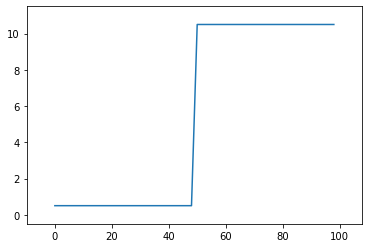

In [5]:
# Take the mean of neighboring pixels
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0
plt.plot(smooth_signal)
plt.margins(0.1)

This same concept, nearest-neighbor averages, can be expressed as a convolution with an averaging kernel:

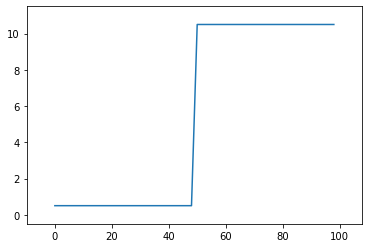

In [6]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/2 and summed
mean_kernel = np.array([1, 1]) / 2.0
smooth_signal = np.convolve(noisy_signal, mean_kernel, mode='valid')
plt.plot(smooth_signal)
plt.margins(0.1)

### Local filtering of images

Now let's apply this to a real image. Let's start with an incredibly simple image:

In [7]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

This gives the values below:

In [8]:
print (bright_square)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


and looks like a white square centered on a black square:

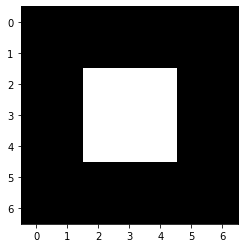

In [9]:
plt.imshow(bright_square);

### Mean filter

For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [10]:
np.ones((3, 3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [11]:
mean_kernel = 1.0/9.0 * np.ones((3, 3))
print (mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Now, let's take our mean kernel and apply it to every pixel of the image using convolution. Let's take a look at the numerical result:

In [12]:
from scipy.ndimage import convolve
%precision 2
smooth = convolve(bright_square, mean_kernel)
print(smooth)

[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


<ipython-input-13-fc42bc38a494>:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  smooth = filters.rank.mean(bright_square,mean_kernel)


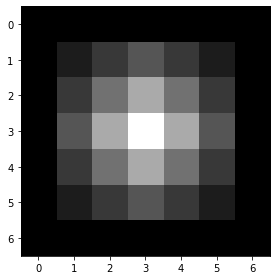

In [13]:
#apply Scipy rank mean function
smooth = filters.rank.mean(bright_square,mean_kernel)
io.imshow(img_as_ubyte(smooth))
io.show()

Each pixel was replaced with the mean value within the 3x3 neighborhood of that pixel. When the kernel was over `n` bright pixels, the pixel in the kernel's center was changed to n/9 (= n * 0.111). When no bright pixels were under the kernel, the result was 0.

This filter is a simple smoothing filter and produces two important results:
1. The intensity of the bright pixel decreased.
2. The intensity of the region near the bright pixel increased.

### Median Filter

The median filter is the classic edge-preserving filter. As the name implies, this filter takes a set of pixels (i.e. the pixels within a kernel or "structuring element") and returns the median value within that neighborhood. Because regions near a sharp edge will have many dark values and many light values (but few values in between) the median at an edge will most likely be either light or dark, rather than some value in between. In that way, we don't end up with edges that are smoothed. 

<ipython-input-14-dc25ca00443b>:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  smooth = filters.rank.median(bright_square,mean_kernel)


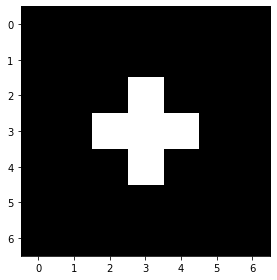

In [14]:
#apply Scipy rank median function
smooth = filters.rank.median(bright_square,mean_kernel)
io.imshow(smooth)
io.show()

### Gaussian filter

The classic image filter is the Gaussian filter. This is similar to the mean filter, in that it tends to smooth images. The Gaussian filter, however, doesn't weight all values in the neighborhood equally. Instead, pixels closer to the center are weighted more than those farther away. For the Gaussian filter, `sigma`, the standard deviation, defines the size of the neighborhood.

[[0.   0.02 0.04 0.05 0.04 0.02 0.  ]
 [0.02 0.09 0.21 0.27 0.21 0.09 0.02]
 [0.04 0.21 0.48 0.61 0.48 0.21 0.04]
 [0.05 0.27 0.61 0.78 0.61 0.27 0.05]
 [0.04 0.21 0.48 0.61 0.48 0.21 0.04]
 [0.02 0.09 0.21 0.27 0.21 0.09 0.02]
 [0.   0.02 0.04 0.05 0.04 0.02 0.  ]]


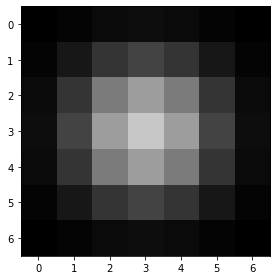

In [15]:
sigma = 1
smooth = filters.gaussian(bright_square, sigma)
print(smooth)
io.imshow(smooth)
io.show()

### Filters applied to real images 

[[200 198 199 ... 190 190 190]
 [200 200 200 ... 191 191 191]
 [202 201 201 ... 193 193 192]
 ...
 [ 21  21  22 ... 124 140 149]
 [ 24  22  24 ... 130 153 159]
 [ 25  24  23 ... 138 165 141]]


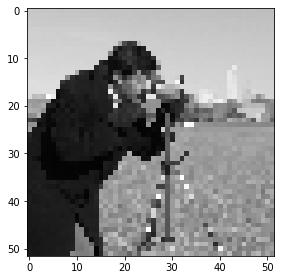

In [16]:
from skimage import img_as_float
# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.
image = data.camera()
pixelated = image[::10, ::10]

print(pixelated)

pixelated_float = img_as_float(pixelated)
io.imshow(pixelated_float)
io.show()

The Gaussian filter is typically preferred because of the distance-dependent weighting. These difference is more noticeable with a more detailed image. The size of the structuring element used for the mean filter and the size (standard deviation) of the Gaussian filter are tweaked to produce an approximately equal amount of smoothing in the two results.

Text(0.5, 1.0, 'Gaussian')

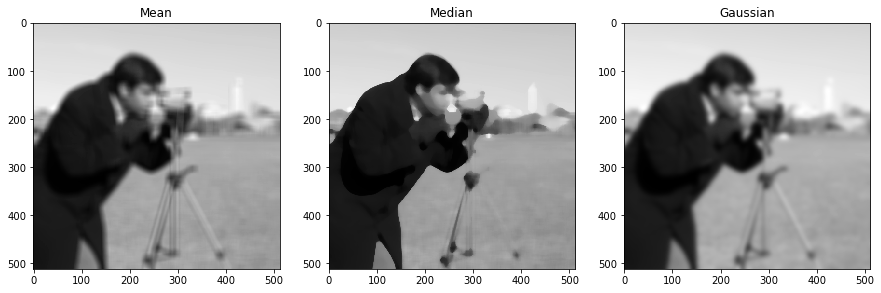

In [17]:
#define structural element - a neighborhood expressed as a 2-D array of 1’s and 0’s.
size = 5
selem = np.ones((3*size, 3*size))

#apply rank filters
smooth_mean = filters.rank.mean(image, selem)
smooth_median = filters.rank.median(image, selem)

#apply gaussian filters
smooth_gaussian = filters.gaussian(image, size)

#Display filtered images
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

#Mean Filter
ax1.imshow(smooth_mean)
ax1.set_title('Mean')

#Median Filter
ax2.imshow(smooth_median)
ax2.set_title('Median')          
          
#Gaussian Filter
ax3.imshow(smooth_gaussian)
ax3.set_title('Gaussian')

### Exercise
Apply Mean, Median and Gaussian filters on pixelated version of the coins image from the dataset. Which filter gives good edge detection ? Try with filters (selems) of different sizes.

In [ ]:
coins = data.coins()
plt.imshow(coins)

### Noise removal using Median filters
Some noise is added to the image, 1% of pixels are randomly set to 255, 1% are randomly set to 0. The <strong>median</strong> filter is applied to remove the noise. The structuring elements applied here are disk shaped.

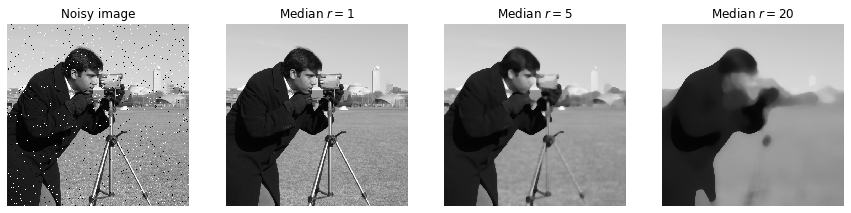

In [18]:
#add noise
noisy_image = img_as_ubyte(data.camera())
noise = np.random.random(noisy_image.shape)
noisy_image[noise > 0.99] = 255
noisy_image[noise < 0.01] = 0

#display images
fig, ax = plt.subplots(1, 4, figsize=(15, 7), sharex=True, sharey=True)
ax1, ax2, ax3, ax4 = ax.ravel()

ax1.imshow(noisy_image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax1.set_title('Noisy image')
ax1.axis('off')

ax2.imshow(median(noisy_image, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax2.set_title('Median $r=1$')
ax2.axis('off')


ax3.imshow(median(noisy_image, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax3.set_title('Median $r=5$')
ax3.axis('off')


ax4.imshow(median(noisy_image, disk(20)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax4.set_title('Median $r=20$')
ax4.axis('off')

plt.show()

### Excercise

Apply Gaussian filters with different sigma values to the astronaut image. Observe various levels of smoothing achieved. 

In [ ]:
#data.astronaut()